# Assignment

Document classification has been one of the most successful applications of the naive Bayes model. There is a good chance that the SPAM filter your email service uses is a naive Bayes model, at least in part.

We say that we classify documents by **topics**. The naive Bayes topic model computes the probability that a document $D$ has topic $C$ based on the occurrence of the words $\{ w_1, w_2, \ldots, w_n \}$, using the following relationship:

$$p(C|D) \propto \prod_{j = 1}^N p(w_j|C)$$

Notice that this topic model allows a document to have a number of topics. For example, we can say the topics of $D$ are the 5 topics with the highest probability.

For a SPAM classifier, the topics are just spam and not spam, so we only need a Bernoulli topic model:

$$p(S+|D) \propto p(S+) \prod_{j=1}^N p(w_j|S+)$$

For this assignment we will use the `HouseVotes84` data which contains political party and votes on 16 important bills for 435 members of the US House of Representatives in 1984. We will use this data set to build and test a classifier to predict the political party of representatives.

In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import naive_bayes
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix

import matplotlib
matplotlib.rcParams['figure.figsize'] = [15, 5]

In [66]:
vote_names = [
    'handicapped_infants',
    'water_project_cost_sharing',
    'adoption_of_the_budget_resolution',
    'physician_fee_freeze',
    'el_salvador_aid',
    'religious_groups_in_schools',
    'anti_satellite_test_ban',
    'aid_to_nicaraguan_contras',
    'mx_missile',
    'immigration',
    'synfuels_corporation_cutback',
    'education_spending',
    'superfund_right_to_sue',
    'crime',
    'duty_free_exports',
    'export_administration_act_south_africa']

#import dataframe
votes = pd.read_csv('./data/house-votes-84.csv', 
                    header = None, names = ['party'] + vote_names)
#rows x columns
print(votes.shape)
#print top 5 rows
votes.head()

(435, 17)


,party,handicapped_infants,water_project_cost_sharing,adoption_of_the_budget_resolution,physician_fee_freeze,el_salvador_aid,religious_groups_in_schools,anti_satellite_test_ban,aid_to_nicaraguan_contras,mx_missile,immigration,synfuels_corporation_cutback,education_spending,superfund_right_to_sue,crime,duty_free_exports,export_administration_act_south_africa
0,republican,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?
2,democrat,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y


1 / 6
- Reshape the data from wide to long, so the new data called `votes_long` has only three columns: `party`, `issue` and `vote`. HINT: You can use the `melt` method to reshape the data. <span style="color:red" float:right>[5 point]</span>

In [68]:
#copy the dataframe
votes_long = votes.copy()
#take the columns of the dataframe
votes_long_columns = np.array(votes_long.columns)
# remove column "party" from this list
votes_long_columns = np.delete(votes_long_columns, np.where(votes_long_columns =='party'))
#Reshape the data from wide to long
#Has only 3 columns: party, issue, vote
votes_long = pd.melt(votes_long, id_vars=['party'], value_vars=votes_long_columns, var_name="issue", value_name="vote")
#print top 10 rows for confirmation
votes_long.head(10)

,party,issue,vote
0,republican,handicapped_infants,n
1,republican,handicapped_infants,n
2,democrat,handicapped_infants,?
3,democrat,handicapped_infants,n
4,democrat,handicapped_infants,y
5,democrat,handicapped_infants,n
6,democrat,handicapped_infants,n
7,republican,handicapped_infants,n
8,republican,handicapped_infants,n
9,democrat,handicapped_infants,y


2 / 6
- Visualize the data by looking at a barplot of the frequency of votes by party for each issue. HINT: Use `sns.catplot`. <span style="color:red" float:right>[5 point]</span>

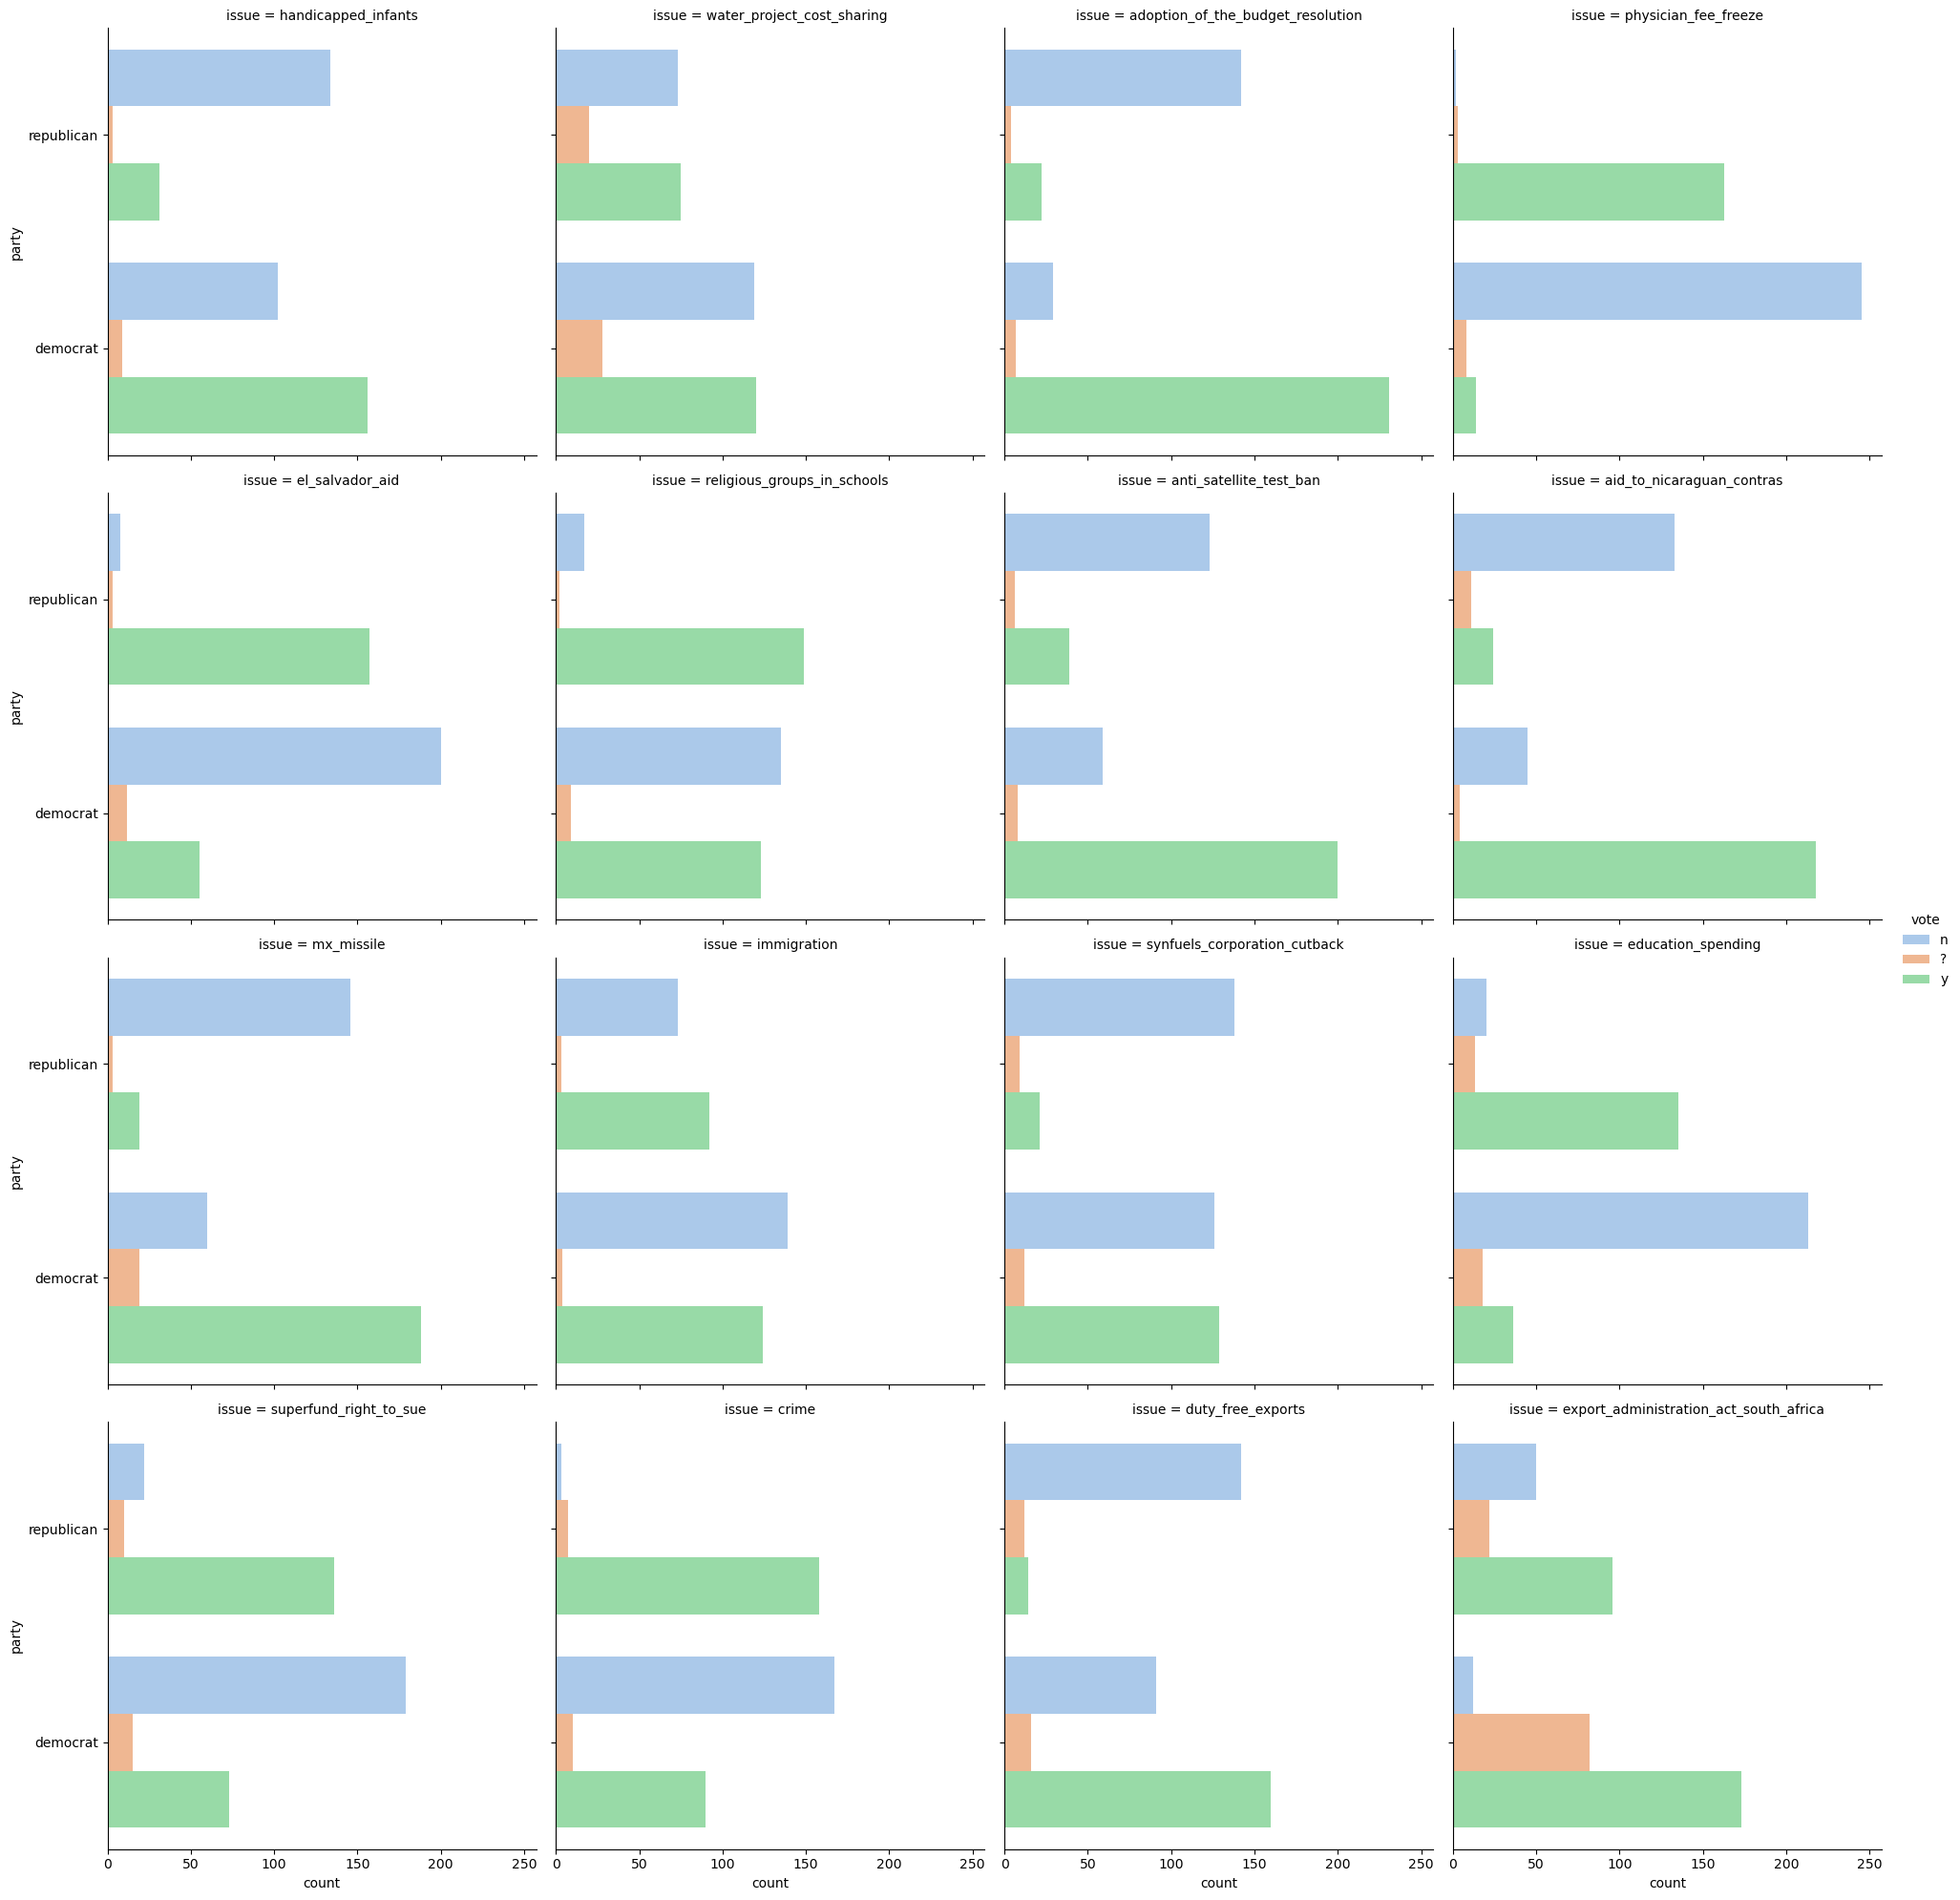

In [70]:
#Visualize the data by looking at a barplot
g=sns.catplot(y = 'party', col="issue", col_wrap = 4, hue = "vote", data = votes_long, kind = 'count', palette="pastel")
    #y is the party, either republican or democrat
    #row is each individual issue
    #hue is votes in each category: yes, no, ?


3 / 6
- Return to the wide data `votes`: Loops though the columns `vote_names` and perform the following: <span style="color:red" float:right>[15 point]</span>
  - Convert the columns into type `category` and limit the categories to `y` and `n`. What happens with all the `?` votes?
  - If there are missing values in these columns, replace the missing values with the majority vote **by party affiliation**. HINT: To look at an example, run `votes.groupby('party')['immigration'].transform(lambda x: x.fillna(x.mode()[0]))`.
  - Replace a `yes` vote with 1 and a `no` vote with 0 (we do this because `sklearn` doesn't like string columns).

In [72]:
for idx, col in enumerate(votes_long_columns): 
    #Convert the columns into type category
    votes[col] = votes[col].astype("category")
    #print to check my answer
    #print(votes[col].cat.categories)
    #limit the categories to y and n
    votes[col] = votes[col].cat.remove_categories(["?"])
    #print to check my answer
    #print(votes[col].value_counts(dropna = False))
        #What happens with all the ? votes?
        #All the ? sets to "NAN"
    #replace the missing values with the majority vote by party affiliation
    votes[col] = votes.groupby("party")[col].transform(lambda x: x.fillna(x.mode()[0]))
    #Replace a yes vote with 1 and a no vote with 0
    votes[col] = votes[col].cat.rename_categories({"n" : 0, "y" : 1}).astype(int)
    #Check that no NAs are left in the data.
    print(votes[col].value_counts(dropna = False))

#Check data types for use later
votes.dtypes


handicapped_infants
0    239
1    196
Name: count, dtype: int64
water_project_cost_sharing
1    243
0    192
Name: count, dtype: int64
adoption_of_the_budget_resolution
1    260
0    175
Name: count, dtype: int64
physician_fee_freeze
0    255
1    180
Name: count, dtype: int64
el_salvador_aid
0    220
1    215
Name: count, dtype: int64
religious_groups_in_schools
1    274
0    161
Name: count, dtype: int64
anti_satellite_test_ban
1    247
0    188
Name: count, dtype: int64
aid_to_nicaraguan_contras
1    246
0    189
Name: count, dtype: int64
mx_missile
1    226
0    209
Name: count, dtype: int64
immigration
1    219
0    216
Name: count, dtype: int64
synfuels_corporation_cutback
0    273
1    162
Name: count, dtype: int64
education_spending
0    251
1    184
Name: count, dtype: int64
superfund_right_to_sue
1    219
0    216
Name: count, dtype: int64
crime
1    255
0    180
Name: count, dtype: int64
duty_free_exports
0    245
1    190
Name: count, dtype: int64
export_administration_act_

party                                     object
handicapped_infants                        int32
water_project_cost_sharing                 int32
adoption_of_the_budget_resolution          int32
physician_fee_freeze                       int32
el_salvador_aid                            int32
religious_groups_in_schools                int32
anti_satellite_test_ban                    int32
aid_to_nicaraguan_contras                  int32
mx_missile                                 int32
immigration                                int32
synfuels_corporation_cutback               int32
education_spending                         int32
superfund_right_to_sue                     int32
crime                                      int32
duty_free_exports                          int32
export_administration_act_south_africa     int32
dtype: object

In [73]:
#check party vs issue
pd.crosstab(votes['party'], votes['superfund_right_to_sue'])

superfund_right_to_sue,0,1
party,,
democrat,194,73
republican,22,146


4 / 6
Make sure that no NAs are left in the data. Time to train a classifier to predict party affiliation based on how someone votes on the above issues. The model will predict the probability of being a Democrat. For simplicity, we assume that the probability of being a Republican is 1 minus that of being a Democrat.

- Train a multinomial naive Bayes classifier to predict whether someone is a Democrat based on their vote. To keep things simple, you do NOT need to split the data into training and testing. <span style="color:red" float:right>[10 point]</span>

In [75]:
#multinomial naive Bayes classifier

#CREATE a model
rng = np.random.RandomState(1)
model = naive_bayes.MultinomialNB()
#set data as inputs and outputs
X = votes[votes_long_columns]
#print(X.head())
y = votes["party"]
#print(y.head())
#TRAIN by fitting: input is votes, output is party
model.fit(X, y)
#PREDICT: store the model's predicted party affilation in it
votes["pred_party"] = model.predict(X)
print(votes.head(5))
#EVALUATE the score of model: Get the accuracy
mean_accuracy = model.score(X,y)
print(mean_accuracy)

        party  handicapped_infants  water_project_cost_sharing  \
0  republican                    0                           1   
1  republican                    0                           1   
2    democrat                    1                           1   
3    democrat                    0                           1   
4    democrat                    1                           1   

   adoption_of_the_budget_resolution  physician_fee_freeze  el_salvador_aid  \
0                                  0                     1                1   
1                                  0                     1                1   
2                                  1                     0                1   
3                                  1                     0                0   
4                                  1                     0                1   

   religious_groups_in_schools  anti_satellite_test_ban  \
0                            1                        0   
1         

- Create a new column in the data called `pred_party` and store the model's predicted party affilation in it. Note that you will need to express the predictions in terms of party affiliation: `democrat` or `republican`. <span style="color:red" float:right>[10 point]</span>

In [77]:
## Did above

- Get the accuracy and confusion matrix. <span style="color:red" float:right>[5 point]</span>

The score is 91.49 %

[[241  26]
 [ 11 157]]


[Text(0, 0.5, 'democrat'), Text(0, 1.5, 'republican')]

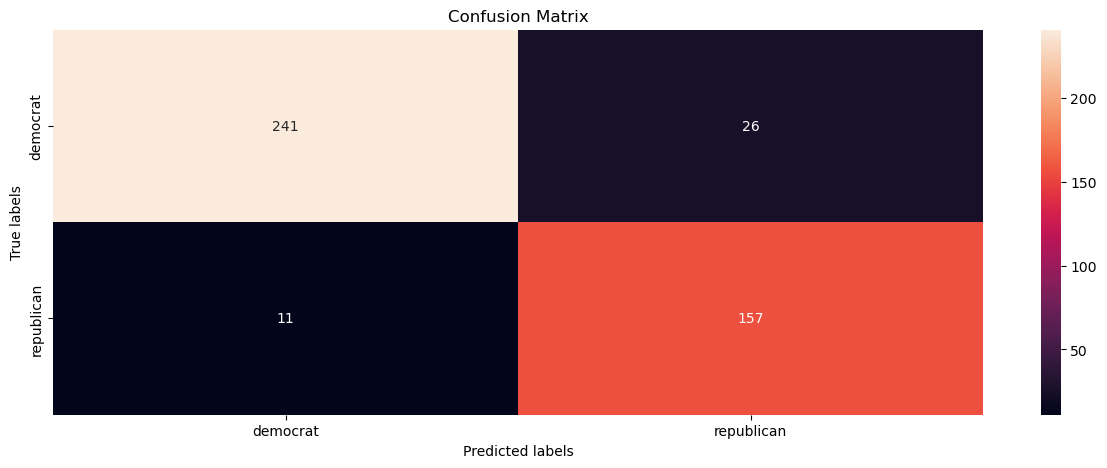

In [79]:
y_pred = votes["pred_party"]

## Get the accuracy
score = accuracy_score(y, y_pred)*100
print("The score is", round(score, 2), "%")
print()

## Get confusion matrix
matrix = confusion_matrix(y, y_pred, labels = ["democrat","republican"])
print(matrix)

#print neatly as a heatmap with labels 
ax = sns.heatmap(matrix, annot = True, fmt = 'g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
ax.xaxis.set_ticklabels(["democrat","republican"])
ax.yaxis.set_ticklabels(["democrat","republican"])

# End of assignment